In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
import seaborn as sns
torch.cuda.empty_cache()

In [ ]:
# Define Gaussian Mixture Model function
def sample_gmm(K, weights, means, covs, M):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    weights = torch.tensor(weights, device=device)
    means = [torch.tensor(mean, device=device) for mean in means]
    covs = [torch.tensor(cov, device=device) for cov in covs]
    normal_distributions = [torch.distributions.MultivariateNormal(mean, cov) for mean, cov in zip(means, covs)]
    categorical_distribution = torch.distributions.Categorical(weights)
    samples = []
    scores = []
    for _ in range(M):
        component_idx = categorical_distribution.sample()
        sample = normal_distributions[component_idx].sample()
        samples.append(sample)
    return torch.stack(samples)

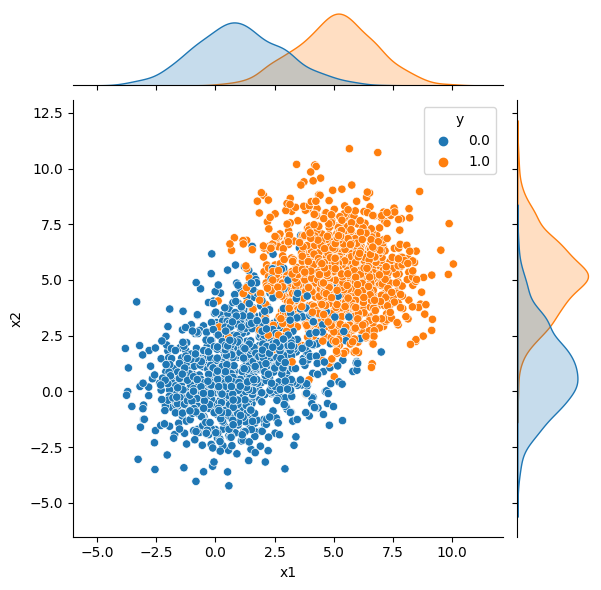

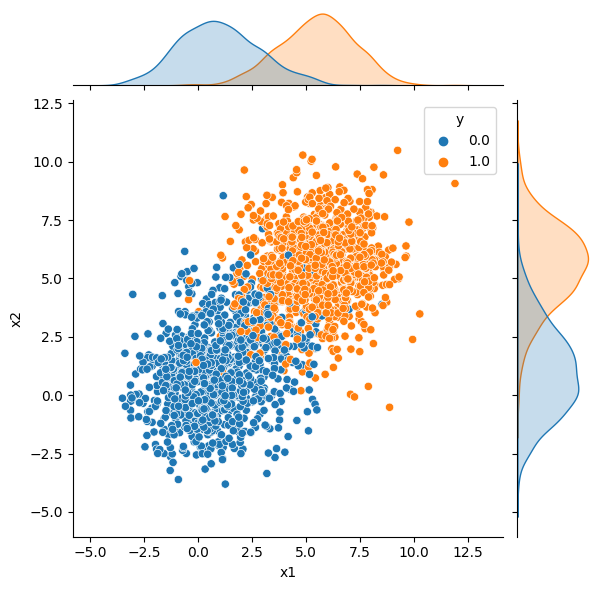

In [ ]:
def generate_binary_dataset(y0_params, y1_params):
  samples_y0 = sample_gmm(y0_params['K'], y0_params['weights'], y0_params['means'],
                          y0_params['covs'], y0_params['M']).numpy()
  samples_y1 = sample_gmm(y1_params['K'], y1_params['weights'], y1_params['means'],
                          y1_params['covs'], y1_params['M']).numpy()
  d = {'x1':np.concatenate([samples_y0[:, 0],samples_y1[:, 0]]) ,
      'x2':np.concatenate([samples_y0[:, 1], samples_y1[:, 1]]),
      'y':np.concatenate([np.zeros_like(samples_y0[:, 1]), np.ones_like(samples_y1[:, 1])])}
  data = pd.DataFrame(data=d)
  return data.sample(frac=1)


M1 = 1000
# For Y=0: Define parameters for Gaussian Mixture Model
y0_params = {'K':2, 'weights':[0.5, 0.5], 'means':[[0., 0.], [2., 2.]],
                'covs': [[[2., 0.], [0., 2.]], [[3., 0.], [0., 3.]]], 'M': M1}

# For Y=0: Define parameters for Gaussian Mixture Model
y1_params = {'K':2, 'weights':[0.9, 0.1], 'means':[[5., 5.], [6., 6.]],
                'covs': [[[3., 0.], [0., 3.]], [[2., 0.], [0., 2.]]], 'M': M1}

data_s = generate_binary_dataset(y0_params, y1_params)

sns.jointplot(data=data_s, x="x1", y="x2", hue="y")
M1 = 1000
# For Y=0: Define parameters for Gaussian Mixture Model
y0_params = {'K':2, 'weights':[0.5, 0.5], 'means':[[0., 0.], [2., 2.]],
                'covs': [[[2., 0.], [0., 2.]], [[3., 0.], [0., 3.]]], 'M': M1}

# For Y=0: Define parameters for Gaussian Mixture Model
y1_params = {'K':2, 'weights':[0.5, 0.5], 'means':[[5., 5.], [6., 6.]],
                'covs': [[[3., 0.], [0., 3.]], [[2., 0.], [0., 2.]]], 'M': M1}

data_t = generate_binary_dataset(y0_params, y1_params)

sns.jointplot(data=data_t, x="x1", y="x2", hue="y")

In [ ]:
datas = np.array(data_s)
datat = np.array(data_t)
datas = torch.tensor(datas)
datat = torch.tensor(datat)

data1 = datas[:100,:2]
labels1 = datas[:100,2]
dataset1 = TensorDataset(torch.tensor(data1, dtype=torch.float32), torch.tensor(labels1, dtype=torch.float32))


data2 = datat[1000:1010,:2]
labels2 = datat[1000:1010,2]
dataset2 = TensorDataset(torch.tensor(data2, dtype=torch.float32), torch.tensor(labels2, dtype=torch.float32))

test_data = datat[1180:1200,:2]
test_labels = datat[1180:1200,2]
test_dataset = TensorDataset(torch.tensor(test_data, dtype=torch.float32), torch.tensor(test_labels, dtype=torch.float32))

dataloader1 = DataLoader(dataset1, batch_size=16, shuffle=True)
dataloader2 = DataLoader(dataset2, batch_size=16, shuffle=True)
dataloader3 = DataLoader(test_dataset, batch_size=16, shuffle=True)

criterion = nn.BCELoss()

<ipython-input-4-e5004e401a32>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset1 = TensorDataset(torch.tensor(data1, dtype=torch.float32), torch.tensor(labels1, dtype=torch.float32))
<ipython-input-4-e5004e401a32>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset2 = TensorDataset(torch.tensor(data2, dtype=torch.float32), torch.tensor(labels2, dtype=torch.float32))
<ipython-input-4-e5004e401a32>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = TensorDataset(torch.tensor(test_data, dtype=torch.float32), torch

In [ ]:

class ThreeLayerNet(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(ThreeLayerNet, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    self.fc3 = nn.Linear(hidden_size, output_size)
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.sigmoid(self.fc3(x))
    return x


In [ ]:
def acc(predictions, test_labels):
  true_predictions=0
  for i, pred in enumerate(predictions):
    term = 1 if pred >= 0.5 else 0
    if term == test_labels[i]:
      true_predictions += 1
  return true_predictions/len(test_labels)


In [ ]:
import torch.nn.functional as F
# Training loop
resultFL=[]
torch.manual_seed(42)

input_size = 2
hidden_size = 8
output_size = 1
learning_rate = 0.01
num_epochs = 2000
num_train_iterations = 1
# Create the model

node11_model = ThreeLayerNet(input_size, hidden_size, output_size)
node22_model =  ThreeLayerNet(input_size, hidden_size, output_size)
aggregated_model =  ThreeLayerNet(input_size, hidden_size, output_size)
node1_optimizer = optim.SGD(node11_model.parameters(), lr=0.01)
node2_optimizer = optim.SGD(node22_model.parameters(), lr=0.01)

fl_accuracy = []
source_accuracy = []
source_loss = []
target_accuracy = []

for train_iteration in range(num_train_iterations):
  result = []
  for epoch in range(num_epochs):
    outputs = node11_model(data1)
    loss = criterion(outputs.squeeze(), labels1.squeeze(-1))
    node1_optimizer.zero_grad()
    loss.backward()
    node1_optimizer.step()
    source_loss.append(loss.item())

    outputs = node22_model(data2)
    loss = criterion(outputs.squeeze(), labels2.squeeze(-1))
    node2_optimizer.zero_grad()
    loss.backward()
    node2_optimizer.step()

    state_dict_m1 = node11_model.state_dict()
    state_dict_m2 = node22_model.state_dict()
    state_dict_aggregated = aggregated_model.state_dict()
    for param_name in state_dict_aggregated:
      param_m1 = state_dict_m1[param_name]
      param_m2 = state_dict_m2[param_name]
      averaged_param = (param_m1 + param_m1) / 2.0
      state_dict_aggregated[param_name] = averaged_param
    aggregated_model.load_state_dict(state_dict_aggregated)
    with torch.no_grad():
      source_predictions = node11_model(torch.tensor(test_data, dtype=torch.float32))
      source_accuracy.append(acc(source_predictions, test_labels))

      predictions = aggregated_model(torch.tensor(test_data, dtype=torch.float32))
      target_predictions = node22_model(torch.tensor(test_data, dtype=torch.float32))
      fl_accuracy.append(acc(predictions, test_labels))
      target_accuracy.append(acc(target_predictions, test_labels))


      # true_predictions=0
      # for i, pred in enumerate(predictions):
      #   term = 1 if pred >= 0.5 else 0
      #   if term == test_labels[i]:
      #     true_predictions += 1
  resultFL.append(result)


acc_FFL = torch.mean(torch.tensor(resultFL), dim=0)

<ipython-input-7-bb90ac6bc4d6>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  source_predictions = node11_model(torch.tensor(test_data, dtype=torch.float32))
<ipython-input-7-bb90ac6bc4d6>:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = aggregated_model(torch.tensor(test_data, dtype=torch.float32))
<ipython-input-7-bb90ac6bc4d6>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_predictions = node22_model(torch.tensor(test_data, dtype=torch.float32))


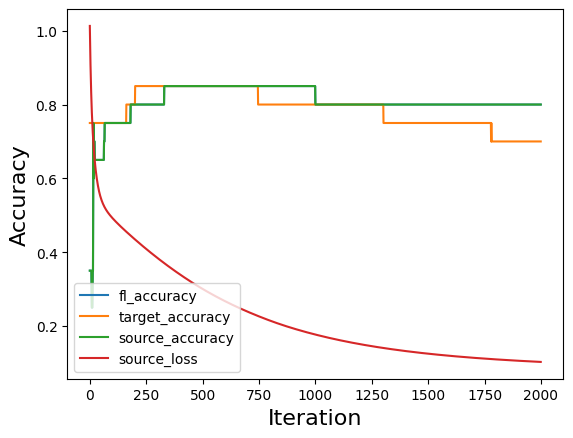

In [ ]:
# plt.plot(avg_accuracies0, label="Target-Test Accuracy")
# plt.plot(avg_accuracies5, label="Test, alpha=0.5")
# plt.plot(acc_FL, label="Test FL")
plt.plot(fl_accuracy, label="fl_accuracy")
plt.plot(target_accuracy, label="target_accuracy")
plt.plot(source_accuracy, label="source_accuracy")
plt.plot(source_loss, label="source_loss")

plt.xlabel(r"Iteration", fontsize=16)
plt.ylabel(r"Accuracy", fontsize=16)
plt.title("")
plt.legend(loc="lower left")
#plt.style.use('ggplot')
plt.savefig('books_read.png')
plt.show()

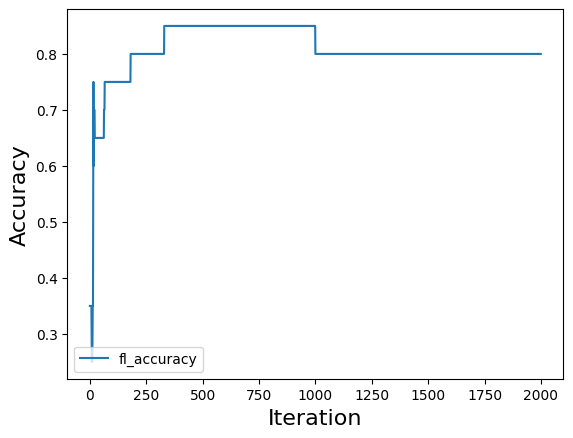

In [ ]:
plt.plot(fl_accuracy, label="fl_accuracy")


plt.xlabel(r"Iteration", fontsize=16)
plt.ylabel(r"Accuracy", fontsize=16)
plt.title("")
plt.legend(loc="lower left")
#plt.style.use('ggplot')
plt.savefig('books_read.png')
plt.show()

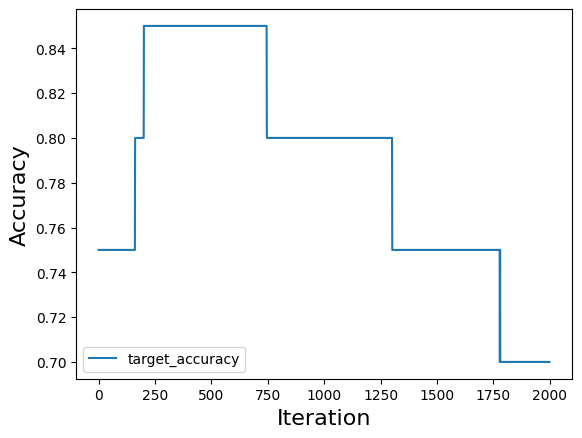

In [ ]:
plt.plot(target_accuracy, label="target_accuracy")

plt.xlabel(r"Iteration", fontsize=16)
plt.ylabel(r"Accuracy", fontsize=16)
plt.title("")
plt.legend(loc="lower left")
#plt.style.use('ggplot')
plt.savefig('books_read.png')
plt.show()